# CS 503 Foundation Models: Part 1 - nanoGPT

We build nano4M in three parts:
1) In this first part, we start by implementing the necessary building blocks to construct an autoregressive Transformer, like GPT.
2) In part 2, we will build a masked model in the style of MaskGIT. 
3) In part 3, we will build a simple 4M-like multimodal model.

#### Goals:

The goal of this first part is to familiarize yourself with the following topics:
- Causal attention
- Transformer decoder-only (e.g. GPT, LLaMA, ...) models
- Basic tokenization
- Basic positional encodings
- Autoregressive modelling on text and images
- Autoregressive inference

This notebook should give you a solid foundation of working with autoregressive Transformer models and get you "thinking with tokens".

If you want to know more about these topics, please see some of the reading material in the lectures and at the bottom of this notebook, and feel free to ask the TAs.


#### Instructions:

- Your task is to fill in the missing code in the accompanying codebase (highlighted by `???`), run the training loops and evaluate the trained models with this notebook.
- Submit the notebook with all cells executed.
- The notebooks are individual homework.

---

## 1 Setup

### 1.1 Dependencies and environment

The notebook should be run on one GPU, while the actual training requires 1-2 GPUs depending on the config.

The required packages for training are specified in `pyproject.toml`. 
We provide a convenience script, `setup_env.sh`, which creates a `nanofm` environment and Jupyter Kernel, and installs the requirements.

After running `bash setup_env.sh`, you can activate the environment with `source activate nanofm`. Similarly, you will have access to the `nano4M kernel (nanofm)` in your Jupyter notebooks for executing the following cells.


### 1.2 Codebase overview

This nano4M codebase is a heavily simplified version of the original 4M codebase. We will use it to implement nano versions of [GPT](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) for autoregressive text and image generation, [MaskGIT](https://masked-generative-image-transformer.github.io/) for masked text and image generation, and [4M](https://4m.epfl.ch/) for multimodal generation.

The codebase is structured in the following manner:

- `cfgs/`: Configs specifying exactly what model to train on what data, for how long, etc.
- `nanofm`: 
    - `data`: Contains various data loaders, e.g. for text, vision, and multimodal datasets.
    - `modeling`: Contains often used modeling utils, such as Transformer layer definitions.
    - `models`: Specific instantiations of models that define the model, forward pass, loss, and generation loop.
    - `utils`: Various helper utils related to training, checkpointing, etc.
- `notebooks`: Check this directory for the instructions for parts 1-3. You will need to submit these notebooks.
- `run_training.py`: This file contains the main training and evaluation loop.

### 1.3 Weights & Biases setup

When training models, it's crucial to log training and validation metrics, as well as stats about the model training that can help to check the health and efficiency of a run.
For example, we will log train and validation losses to check that the model is converging properly and is not not overfitting to the train set.
Besides that, we log the average norm of the gradient updates to check that it is not exploding, as a sign of the health of the training run.

For all of this, we will use Weights & Biases, which also automatically logs system stats like GPU utilization, memory usage, etc.
Please visit https://wandb.ai/ and create an account in case you don't have one already. 

In https://wandb.ai/settings you should see an API key. If not, please create a new one. 
Copy this key and use it to [log in](https://docs.wandb.ai/ref/cli/wandb-login/) by calling `wandb login <KEY>`. You should see the message `wandb: W&B API key is configured`.
You may alternatively log in to wandb by adding it as an environment variable: `export WANDB_API_KEY=<KEY>`.

Now, when running training jobs on a new node, make sure to log in before starting the training, and remember to fill the `wandb_entity` entry in the configs with your wandb user name.

### 1.3 Imports

In [1]:
# Switch path to root of project
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2

In [2]:
import re
import torch
from einops import rearrange
from transformers import AutoTokenizer
from tokenizers.processors import TemplateProcessing

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from nanofm.utils.checkpoint import load_model_from_safetensors
from nanofm.data.vision.tokenized_mnist import create_tokenized_mnist_dataloader, detokenize_MNIST

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")
torch.set_grad_enabled(False)

/home/balducci/miniconda3/envs/nanofm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


---

## 2 Training nanoGPT on TinyStories for text generation

In this exercise, we will implement a simplified autoregressive Transformer, similar to nanoGPT. 
We will train it on [TinyStories](https://arxiv.org/abs/2305.07759), a synthetically generated dataset of somewhat simple children's book stories. That focus allows us to train relatively small models that can generate coherent text and demonstrate some basic world knowledge.

### 2.1 Overview and tasks

To implement nanoGPT, we ask you to complete the subsections below by directly filling in the missing lines in the code base.

Hint: After completing the implementation of nanoGPT, in case you are still debugging, you may want to run the image generation examples in section 3 first. They are significantly faster to train and may facilitate faster debugging.

#### 2.1.1 MLP layer (10 points)

In `nanofm.modeling.transformer_layers.Mlp`, implement the following two-layer Perceptron:

$$ \text{MLP}(X) = \text{GeLU}(X W_1^T + b_1) W_2^T + b_2 $$

Here, $\text{GeLU}$ denotes the [GeLU activation function](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html). 
The first linear layer projects x from dimension `in_features` to `hidden_features`, while the second projects it back to `out_features`.
Commonly, the bias terms are disabled. Make sure to take into account the `bias` argument.

#### 2.1.2 (Masked) self-attention layer (20 points)

Next, we ask you to implement a layer that performs (optionally masked) multi-headed self-attention in `nanofm.modeling.transformer_layers.Attention`.

Remember the scaled dot-product attention formula:
$$ \text{Attention}(Q, K, V) = \text{softmax}_\text{row} \left( \frac{Q K^T}{\sqrt{d_k}} \right) V $$

The queries $Q$, the keys $K$, and the values $V$ are all linear projections of $X$:

$$ Q(X) = X W_Q^T $$
$$ K(X) = X W_K^T $$
$$ V(X) = X W_V^T $$

The scaling factor $d_k$ is the dimensionality of the keys $K$, i.e. `dim // num_heads`.

The attention is performed on `num_heads` heads in parallel (don't use a for loop) in `head_dim = dim // num_heads`-dimensional subspaces and the results are concatenated along the feature dimension.

In addition, we want to enable masking of the attention matrix, e.g. for implementing a Transformer decoder.
For this, the forward function takes an additional `mask` argument, specifying where to zero-out the attention matrix.
In practice, this is implemented by replacing the values of the attention matrix (pre softmax) to minus infinity wherever we don't want any attention flow.

#### 2.1.3 Transformer block (10 points)

Next, implement a Transformer block in `nanofm.modeling.transformer_layers.Block`. It is defined as:

$$ X_a = X + \text{Attention}(\text{LN}(X)) $$
$$ X_b = X_a + \text{MLP}(\text{LN}(X_a)) $$

Here, $\text{LN}$ denotes (two separate) LayerNorm layers.

Don't forget to pass the optional mask to the self-attention layer!

#### 2.1.4 Assembling the blocks into a Transformer tunk (10 points)

Now we have all the building blocks to create a Transformer trunk! 

In `nanofm.modeling.transformer_layers.TransformerTrunk`, create an `torch.nn.ModuleList` containing multiple Transformer blocks, and in the forward pass call them one after another.
Again, make sure to pass the mask!

#### 2.1.5 Initialize nanoGPT, implement the forward function, and loss (20 points)

Finally, we can use this Transformer trunk to build a nanoGPT model, which we implement in `nanofm.models.gpt.GPT`.
It consists of a few operations executed in series. Initialize the following modules in the constructor:
1. The discrete input tokens are embedded with an `nn.Embedding` layer. Initialize `self.input_embedding` accordingly, taking into account the vocabulary size.
2. On top of that, we add learnable positional embeddings. Initialize `self.positional_embedding` as an `nn.Parameter` containing a randomly initialized Tensor of shape (`max_seq_len`, `dim`).
3. This then gets passed to a Transformer trunk. Initialize `self.trunk` with the trunk you just implemented.
4. Finally we project the trunk output through a LayerNorm and output projection that maps the elements from the Transformer dimension to the vocabulary size (as a one-hot vector per token). Initialize `self.out_norm` and `self.to_logits`. The bias term for `self.to_logits` should always be set to False.

Next, let's implement the `forward_model` function:
1. Pass the input tokens through the embedding, add the positional embedding (make sure to account for the length of the inputs!), pass it through the Transformer trunk, output normalization, and output projection.
2. When calling the Transformer trunk, make sure to pass a causal attention mask of shape (1, L, L), where L is the sequence length. The mask is of boolean type, and wherever it is False the attention is masked-out (i.e. set to -infinity), and otherwise it is left untouched. Remember the shape of the attention mask.

Finally, we need to compute the cross-entropy loss between the logits and the ground-truth targets. Please complete the `compute_ce_loss` function accordingly, and take into account the padding token. We do not want to compute a loss on those.

#### 2.1.6 Write the generation loop (20 points)

Now we could theoretically train a model, but it would be of no use without a `generate` function. 
In this function you will run the model in a loop:
1. Given the context so far, run the forward function to get the logits. 
2. Extract the logits of only the last token (it's the next token prediction we care about). 
3. Sample from the probability distribution specified by the last token logits. You can use the helper function `nanofm.utils.sampling.sample_tokens` for that. Make sure to pass the temperature, top-k, and top-p arguments.
4. Concatenate the predicted next token with the context. This will be your new context for the next round. 
5. Respect the halting conditions: A) If you reach the maximum sequence length, stop generating. Take into account the length of the context so far! B) (Optional) In case you generate an `[EOS]` token corresponding to the end-of-sequence, stop generating early.
6. Finally after doing the entire loop and halting, return the sequence.

#### 2.1.7 Text tokenizer overview

For this part, you will not need to implement anything. This is to familiarize you with the text tokenizer we use.
A text tokenizer's job is to take any text and turn it into a sequence of integers (i.e. encode it) that we can predict autoregressively, and to then turn that original or a predicted sequence back into text.
Text tokenizers come in many shapes and forms, but commonly they turn subwords into a unique token, using a vocabulary of a pre-determined size. 

For nanoGPT, we will use the [GPT-2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) tokenizer. It has a base vocabulary size of 50257, but we will add three more special tokens to it:
- `[PAD]`: Not all samples have the same length, but in order to batch them we need to equalize their lenght. The simplest way to do this is to pad the sequences up to some maximum sequence length, e.g. 256 tokens, using special `[PAD]` tokens. During training, we do not compute a loss on these tokens.
- `[SOS]`: The first token could just be the first token of the text sequence, but we want to be able to perform *unconditional* generation, i.e. we want to be able to generate the entire sequence and not have to give it a first token to start generating. The start-of-sequence token `[SOS]` serves as that marker. We prepend it to every sequence.
- `[EOS]`: Given that not all samples have the same length, we need a way for the model to indicate that it is done generating the next tokens. The end-of-sequence `[EOS]` token serves that purpose.

In [3]:
# Load the GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2", trust_remote_code=True)

# Add padding, start-of-sequence, and end-of-sequence tokens
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.add_special_tokens({
    'bos_token': '[SOS]',
    'eos_token': '[EOS]',
})
tokenizer._tokenizer.post_processor = TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[('[EOS]', tokenizer.eos_token_id), ('[SOS]', tokenizer.bos_token_id)],
)
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[SOS]', 'eos_token': '[EOS]', 'unk_token': '<|endoftext|>', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50257: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50258: AddedToken("[SOS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50259: AddedToken("[EOS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

Let's see what happens when we encode sentences of variable length. Remember, we wrap the texts with an `[SOS]` (index 50258) and `[EOS]` (index 50259) token, and pad to the maximum sequence length with a `[PAD]` (index 50257) token. If a text is longer than the specified maximum sequence length, we truncate it.

In [4]:
texts = [
    'This is an example.',
    'Once upon a time there was a quick brown fox.',
]
tokens = tokenizer(texts, max_length=10, padding='max_length', truncation=True, return_tensors='pt')['input_ids']
tokens

tensor([[50258,  1212,   318,   281,  1672,    13, 50259, 50257, 50257, 50257],
        [50258,  7454,  2402,   257,   640,   612,   373,   257,  2068, 50259]])

We can use the same tokenizer to turn the sequences back into text:

In [5]:
for token_seq in tokens:
    print(tokenizer.decode(token_seq))

[SOS]This is an example.[EOS][PAD][PAD][PAD]
[SOS]Once upon a time there was a quick[EOS]


Let's define a helper function to filter out the special tokens:

In [6]:
def token_ids_to_text(token_ids, text_tokenizer):
    """ Helper function to turn token sequences back to well-formatted text. """
    decoded = text_tokenizer.decode(token_ids)
    # Remove [SOS], [EOS], and [PAD] tokens along with surrounding horizontal whitespace only.
    decoded = re.sub(r'[ \t]*\[(SOS|EOS|PAD)\][ \t]*', ' ', decoded)
    # Collapse extra horizontal spaces in each line without touching newline characters.
    decoded = '\n'.join([re.sub(r'[ \t]+', ' ', line).strip() for line in decoded.splitlines()])
    return decoded

In [7]:
for token_seq in tokens:
    print(token_ids_to_text(token_seq, text_tokenizer=tokenizer))

This is an example.
Once upon a time there was a quick


### 2.2 Training the model

We defined a training config for you in: `cfgs/nanoGPT/tinystories_d8w512.yaml`. Please familiarize yourself with all parts.
Please don't forget to replace the Weights & Bias entity with your own.

On a 2xV100 node, you can start the training like:
```
OMP_NUM_THREADS=1 torchrun --nproc_per_node=2 run_training.py --config cfgs/nanoGPT/tinystories_d8w512.yaml
```

During training the script saves intermediate checkpoints at regular intervals. In case your training crashes, the training automatically resumes from that last checkpoint.
In case you don't want to resume training and instead start over from scratch, please either delete the checkpoint directory of that run (e.g. in `./outputs/nanoGPT/tinystories_d8w512/`) or rename it.

This training should take over one hour. You should reach a final validation loss around 1.3, and your loss curves should look something like the following:

<img src="./assets/nanoGPT_tinystories.png" alt="nanoGPT TinyStories loss curves" width="1000">

### 2.3 Show your loss curves (10 points)

Screenshot your loss curves and show them here. Add the image to the `assets` directory and change the path in the markdown. You will get 10 points for reasonable loss curves (similar to the sample loss curves above).

<img src="./assets/your_loss_curves.png" alt="nanoGPT TinyStories loss curves" width="1000">

### 2.4 Evaluating the model (10 points)

After you completed the training, load the model with the following cell. You may need to adjust the path if you changed it.
You will get 10 points if the outputs look reasonable (similar to the sample outputs provided below).

Hint: You can also load intermediate safetensors checkpoints to check the progress during training.

In [8]:
ckpt_path = './outputs/nanoGPT/tinystories_d8w512/checkpoint-final.safetensors'
model = load_model_from_safetensors(ckpt_path, device=device)
print(f'{model.get_num_params() / 10**6}M parameters')

FileNotFoundError: [Errno 2] No such file or directory: './outputs/nanoGPT/tinystories_d8w512/checkpoint-final.safetensors'

Let's generate some random (unconditional) stories!

In [9]:
for _ in range(5):
    output = model.generate(context=[tokenizer.bos_token_id], temp=1.0, top_p=0.0, top_k=0.0, eos_idx=tokenizer.eos_token_id)[0]
    print(token_ids_to_text(output, text_tokenizer=tokenizer))
    print('\n' + '-'*50 + '\n')

Once there was a poor family who lived by the edge of a forest. One day, the mother felt something strange. She looked around her edge and saw a crack in the ground. She grabbed a stick and stepped back. Then, she remembered how her grandmother used to send lightening rain. She thought to herself, "I need to do it myself!" So, she knelt back and watched. The rain got heavier and heavier and soon the crack was gone. The mother was so relieved, she hugged her man from last far away.

From then on, the mother listened carefully to Joy every time she went out into the forest. She remembered the rain, the crack, and the rain that led to time's over.

Every time the rain came, even when the bucket in the ground was now filled with water and no rainy day. She was always happy to visit the forest, hoping to see the light come in again soon.

--------------------------------------------------

Once upon a time, there was a little girl named Lily. She had a bed that was very cold and dark. Lily'

We don't have to generate the stories in a completely unconditional way. Let's try to probe the model and see if it learned some world knowledge. 
If we probe the model with the phrase `Daisy was hungry, so she`, we should expect a continuation talking about her getting food. 

In [10]:
context = tokenizer.encode('Daisy was hungry, so she')[:-1] # Encode and discard automatically added [EOS] token

for _ in range(5):
    output = model.generate(context=context, temp=1.0, top_p=0.0, top_k=0.0, eos_idx=tokenizer.eos_token_id)[0]
    print(token_ids_to_text(output, text_tokenizer=tokenizer))
    print('\n' + '-'*50 + '\n')

Daisy was hungry, so she asked her mum for something to eat. Her mum gave her napkins to hold together. Daisy looked at them and smiled, she had found one.

Daisy and her mum sat together on the sofa. Daisy saw a cheese in a cookie. She was so excited and clapped her hands.

Daisy's mum said, "Let's make a cheese sandwich for you to eat.â€ She handed Daisy the napkins.

Daisy's dad caught a hot cheese pie. He said, "Here's a sweet and warm snack! vanish into thin pieces for you." Daisy was so happy.

Daisy's mum said, "That was very generous of us. I'm glad you shower your napkin!" Daisy smiled and said, "Me too!"

--------------------------------------------------

Daisy was hungry, so she went to the kitchen. She heard her mommy's voice and knew her mommy had something special for her. Daisy went to the kitchen and saw mommy cooking something warm and squ disgusting in the kitchen. Daisy was scared, but she went to help. Mommy said, "What do you recognize?" Daisy smiled and said, "wh

### 2.5 Open-ended questions (5 points each)

Please answer the following questions. You may use additional cells to demonstrate your answers if necessary.

- Q2.1: What effect does the temperature have on the generations?
    - A2.1: [Please fill your answer here]
- Q2.2: What about the top_k and top_p parameters?
    - A2.2: [Please fill your answer here]
- Q2.3: Sometimes the generations of this model are not very good. What could we do to improve it further?
    - A2.3: [Please fill your answer here]

---

## 3 Training nanoGPT on MNIST for conditional image generation

In this part, we will train our nanoGPT on images, similar in spirit to [iGPT](https://openai.com/research/image-gpt).
What this means is that we turn images into a sequence of discrete tokens and train a decoder-only Transformer to perform next-token-prediction.
At inference time, we can then autoregressively generate new images from the training distribution, conditioned on the class label!

If you have successfully completed the nanoGPT implementation, you can directly re-use it for this step! The only thing we change is the way we represent the data.

### 3.1 Tokenization

First, we need to turn images into sequences of discrete tokens.

A common way of performing tokenization of images is to train a discrete VAE, such as [VQ-GAN](https://arxiv.org/abs/2012.09841) to autoencode images through a discrete bottleneck. This is an entire research field of its own, so we will not go further into that here.

Instead, we will tokenize the images in a much simpler way:
- First, we turn the grayscale images into black and white → each image is now a sequence of 14x14 zeros and ones. In this manner, we would already have a sequence of discrete tokens we could model, but the sequence length of 14x14=192 could be shorter.
- To reduce the sequence length further, we divide the image into 2x2 patches and turn each of the 2x2 patterns into a unique index. If we flatten each 2x2 patch into a sequence of 4 zeros and ones, we can directly interpret them as integers between 0 and 15. This reduces the sequence length by a factor of four. Much more manageable in our toy setting!

While this way of tokenizing is really quite "toy", it is indicative of a common problem when dealing with images and transformers: naively turning images to tokens can result in very large sequence lengths.

Let's plot some examples of the tokenized images. First is the original image, then we show each token, and finally we show the corresponding token sequence. 
The first token is the class-label, and the next 49 are the image tokens in raster-scan order. Their token id was shifted by 10 to account for the additional class token (we share the vocabulary with it).

In [8]:
data_loader = create_tokenized_mnist_dataloader(train=False, add_label_token=True, shuffle=False)
data_dict = next(iter(data_loader))

tokens = data_dict['input_ids']
reconst = detokenize_MNIST(tokens, patch_size=2, account_for_labels=True)
bits = rearrange(reconst, 'b (nh ph) (nw pw) -> b (nh nw) ph pw', ph=2, pw=2)

for i in range(2):
    plt.figure(figsize=(5., 5.)); plt.imshow(reconst[i], cmap='Greys'); plt.show()
    
    fig = plt.figure(figsize=(5., 5.))
    grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=0.1)
    for j, img in enumerate(bits[i]):
        grid[j].imshow(img, cmap='Greys', vmin=0, vmax=1)
    plt.show()
    
    print('Tokens:', tokens[i], '\n\n')

: 

### 3.2 Training the model

We defined a training config for you in: `cfgs/nanoGPT/mnist_d8w512.yaml`. Please familiarize yourself with all parts.
Please don't forget to replace the Weights & Bias entity with your own.

On a 1xV100 node, you can start the training like:
```
OMP_NUM_THREADS=1 torchrun --nproc_per_node=1 run_training.py --config cfgs/nanoGPT/mnist_d8w512.yaml
```

This training should be pretty fast and only take a few minutes. You should reach a final validation loss below 0.45, and your loss curves should look something like the following:

<img src="./assets/nanoGPT_mnist.png" alt="nanoGPT MNIST loss curves" width="1000">

### 3.3 Show your loss curves (10 points)

Screenshot your loss curves and show them here. Add the image to the `assets` directory and change the path in the markdown. You will get 10 points for reasonable loss curves (similar to the sample loss curves above).

<img src="./assets/your_loss_curves.png" alt="nanoGPT MNIST loss curves" width="1000">

### 3.4 Evaluating the model (10 points)

After you completed the training, load the model with the following cell. You may need to adjust the path if you changed it.
You will get 10 points if the outputs look reasonable (similar to the sample outputs provided below).

Hint: You can also load intermediate safetensors checkpoints to check the progress during training.

In [12]:
ckpt_path = './outputs/nanoGPT/mnist_d8w512/checkpoint-final.safetensors'
model = load_model_from_safetensors(ckpt_path, device=device)
print(f'{model.get_num_params() / 10**6}M parameters')

25.200128M parameters


Let's plot some class-conditional generations! We seed the generation by providing the first token, whose index is equal to the number we'd like to generate.

In [13]:
label = 5
output = model.generate(context=[label], temp=0.7, top_p=0.0)
output

tensor([[ 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 13, 13, 10, 10, 10, 10, 15,
         10, 10, 10, 10, 10, 10, 15, 13, 12, 10, 10, 10, 10, 10, 10, 25, 10, 10,
         10, 10, 11, 13, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10]],
       device='cuda:0')

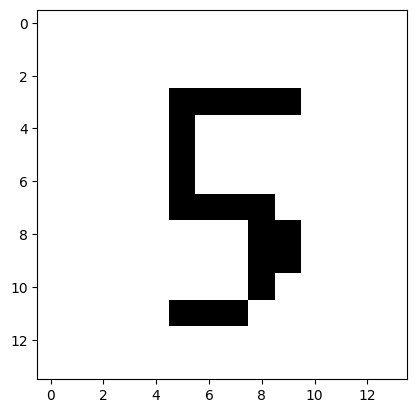

In [14]:
reconst = detokenize_MNIST(output, patch_size=2, account_for_labels=True).cpu()
plt.imshow(reconst[0], cmap='gray_r')

Let's now generate 10 random samples for all 10 classes. Most should look quite reasonable.

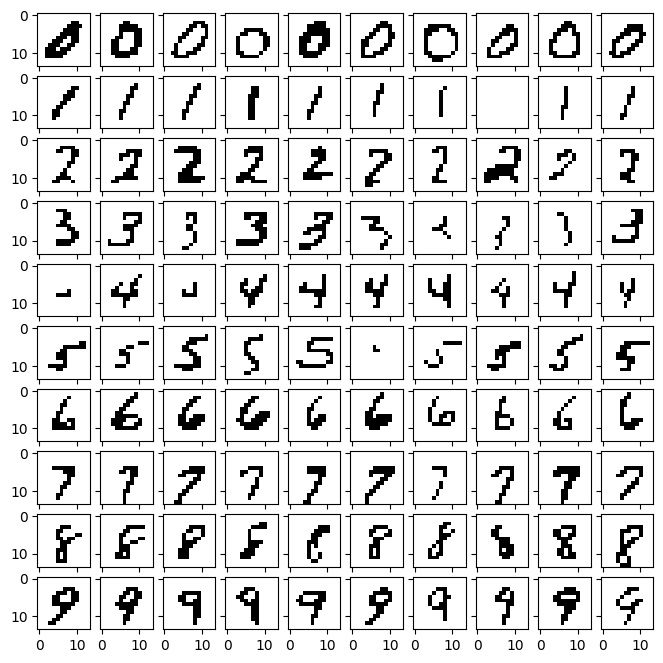

In [15]:
def generate_samples(model, temp=1.0, top_p=0.0, top_k=0.0, n_samples=10):
    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111, nrows_ncols=(10, n_samples), axes_pad=0.1)
    for label in range(10):
        for sample_idx in range(n_samples):
            grid_idx = label * n_samples + sample_idx
            output = model.generate(context=[label], temp=temp, top_p=top_p, top_k=top_k)
            reconst = detokenize_MNIST(output, patch_size=2, account_for_labels=True).cpu()
            grid[grid_idx].imshow(reconst[0], cmap='Greys', vmin=0, vmax=1)
    plt.show()
    
generate_samples(model, temp=0.7, top_p=0.9, top_k=0.0)

### 3.5 Open-ended questions (5 points each)

Please answer the following questions. You may use additional cells to demonstrate your answers if necessary.

- Q3.1: What effect does the temperature have on the generations?
    - A3.1: [Please fill your answer here]
- Q3.2: What about the top_k and top_p parameters?
    - A3.2: [Please fill your answer here]
- Q3.3: How might we extend this to text-to-image?
    - A3.3: [Please fill your answer here]

## 4 Further reading

Having implemented causal-attention, as well as a decoder-only Transformer, you should not have a hard time implementing cross-attention and a full encoder-decoder Transformer to train on arbitrary sequence-to-sequence tasks.
We will explore these topics in the next weeks.
That said, here is some further reading material should you want to dive deeper.

### 4.1 Papers & Blogs

- [Attention Is All You Need, Vaswani et al. 2017 (Original Transformer paper)](https://arxiv.org/abs/1706.03762)
- [Language Models are Unsupervised Multitask Learners, Radford et al. 2018 (GPT-2 paper)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
- [Language Models are Few-Shot Learners, Brown et al. 2020 (GPT-3 paper)](https://arxiv.org/abs/2005.14165)
- [PaLM: Scaling Language Modeling with Pathways, Chrowdherry et al. 2022](https://arxiv.org/abs/2204.02311)
- [LLaMA: Open and Efficient Foundation Language Models, Touvron et al. 2023](https://arxiv.org/abs/2302.13971)
- [Llama 2: Open Foundation and Fine-Tuned Chat Models, Touvron et al. 2023](https://arxiv.org/abs/2307.09288)
- [The Llama 3 Herd of Models](https://arxiv.org/abs/2407.21783)
- [Scaling Laws for Neural Language Models, Kaplan et al. 2020](https://arxiv.org/abs/2001.08361)
- [Training Compute-Optimal Large Language Models, Hoffmann et al. (Chinchilla)](https://arxiv.org/abs/2203.15556)
- [Pixel Recurrent Neural Networks, Van den Oord et al. 2016 (PixelCNN)](https://arxiv.org/abs/1601.06759)
- [PixelCNN++: Improving the PixelCNN with Discretized Logistic Mixture Likelihood and Other Modifications, Salimans et al. 2017](https://arxiv.org/abs/1701.05517)
- [Zero-Shot Text-to-Image Generation, Ramesh et al. 2021 (DALL-E 1)](https://arxiv.org/abs/2102.12092)
- [Autoregressive Model Beats Diffusion: Llama for Scalable Image Generation, Sun et al. 2024 (Image generation with simple autoregressive models)](https://arxiv.org/abs/2406.06525)
- [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale, Dosovitskiy et al. 2020 (Vision Transformer paper)](https://arxiv.org/abs/2010.11929)
- [Transformer Circuits Thread](https://transformer-circuits.pub/)
- [The Transformer Family Version 2.0, Lilian Weng 2023](https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/)
- [The Illustrated Transformer, Jay Alammar 2018](https://jalammar.github.io/illustrated-transformer/)

### 4.2 Code bases

- [nanoGPT](https://github.com/karpathy/nanoGPT)
- [Llama model inference code](https://github.com/meta-llama/llama-models)
- [LlamaGen](https://github.com/FoundationVision/LlamaGen)
- [torchtitan](https://github.com/pytorch/torchtitan)
- [lingua](https://github.com/facebookresearch/lingua)

You might find that, in many ways, these repos are not that much different from what we implemented here!